# Benchmarks Results

In [3]:
import os
os.chdir("..")

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from neuralforecast import NeuralForecast
from neuralforecast.losses.numpy import smape
from datasetsforecast.m3 import M3    
from neuralforecast.losses.pytorch import SMAPE
import hydra
from omegaconf import DictConfig


## models
from neuralforecast.auto import AutoDeepAR, AutoNBEATS, AutoNHITS, AutoTFT, AutoTCN, AutoRNN, AutoLSTM
from neuralforecast.models import DeepAR, NBEATS, NHITS, TFT, TCN, RNN, LSTM

/home/ricardo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-26 00:48:07,645	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-02-26 00:48:07,835	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.



==== Running experiment for dataset: m3_monthly ====
Loading m3_monthly dataset...

--- Evaluating for horizon: 18 ---


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



>>> Running model: nbeats


2025-02-26 00:48:21.779010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740530901.812856  117201 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740530901.823411  117201 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-26 00:48:21.888261: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         |

Epoch 2:  22%|██▏       | 10/45 [00:02<00:08,  4.19it/s, v_num=7, train_loss_step=0.202, train_loss_epoch=0.138, valid_loss=0.148]

Epoch 2, global step 100: 'ptl/val_loss' reached 0.14726 (best 0.14726), saving model to '/home/ricardo/mixture_of_experts_time_series/checkpoints/best_model.ckpt' as top 1


Epoch 4:  44%|████▍     | 20/45 [00:04<00:05,  4.61it/s, v_num=7, train_loss_step=0.133, train_loss_epoch=0.133, valid_loss=0.147] 

Epoch 4, global step 200: 'ptl/val_loss' reached 0.14596 (best 0.14596), saving model to '/home/ricardo/mixture_of_experts_time_series/checkpoints/best_model.ckpt' as top 1


Epoch 6:  67%|██████▋   | 30/45 [00:05<00:02,  5.45it/s, v_num=7, train_loss_step=0.143, train_loss_epoch=0.131, valid_loss=0.146] 

Epoch 6, global step 300: 'ptl/val_loss' reached 0.14505 (best 0.14505), saving model to '/home/ricardo/mixture_of_experts_time_series/checkpoints/best_model.ckpt' as top 1


Epoch 8:  89%|████████▉ | 40/45 [00:07<00:00,  5.56it/s, v_num=7, train_loss_step=0.119, train_loss_epoch=0.128, valid_loss=0.144] 

Epoch 8, global step 400: 'ptl/val_loss' reached 0.14362 (best 0.14362), saving model to '/home/ricardo/mixture_of_experts_time_series/checkpoints/best_model.ckpt' as top 1


Epoch 11:  11%|█         | 5/45 [00:01<00:13,  3.00it/s, v_num=7, train_loss_step=0.148, train_loss_epoch=0.124, valid_loss=0.144]  

Epoch 11, global step 500: 'ptl/val_loss' reached 0.14361 (best 0.14361), saving model to '/home/ricardo/mixture_of_experts_time_series/checkpoints/best_model.ckpt' as top 1


Epoch 13:  33%|███▎      | 15/45 [00:03<00:06,  4.53it/s, v_num=7, train_loss_step=0.150, train_loss_epoch=0.124, valid_loss=0.146] 

Epoch 13, global step 600: 'ptl/val_loss' was not in top 1


Epoch 15:  56%|█████▌    | 25/45 [00:04<00:03,  5.26it/s, v_num=7, train_loss_step=0.114, train_loss_epoch=0.123, valid_loss=0.145] 

Epoch 15, global step 700: 'ptl/val_loss' was not in top 1


Epoch 17:  78%|███████▊  | 35/45 [00:05<00:01,  5.85it/s, v_num=7, train_loss_step=0.108, train_loss_epoch=0.120, valid_loss=0.145] 

Epoch 17, global step 800: 'ptl/val_loss' was not in top 1


Epoch 19: 100%|██████████| 45/45 [00:07<00:00,  5.86it/s, v_num=7, train_loss_step=0.0982, train_loss_epoch=0.119, valid_loss=0.144]

Epoch 19, global step 900: 'ptl/val_loss' was not in top 1


Epoch 22:  22%|██▏       | 10/45 [00:02<00:08,  4.27it/s, v_num=7, train_loss_step=0.0964, train_loss_epoch=0.119, valid_loss=0.146]

Epoch 22, global step 1000: 'ptl/val_loss' was not in top 1


Epoch 22:  22%|██▏       | 10/45 [00:02<00:08,  4.26it/s, v_num=7, train_loss_step=0.0964, train_loss_epoch=0.133, valid_loss=0.146]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 22:  22%|██▏       | 10/45 [00:02<00:08,  4.26it/s, v_num=7, train_loss_step=0.0964, train_loss_epoch=0.133, valid_loss=0.146]


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 64.39it/s]
Model 'nbeats' config 0: sMAPE = 0.138
Mean sMAPE for horizon 18: 0.138


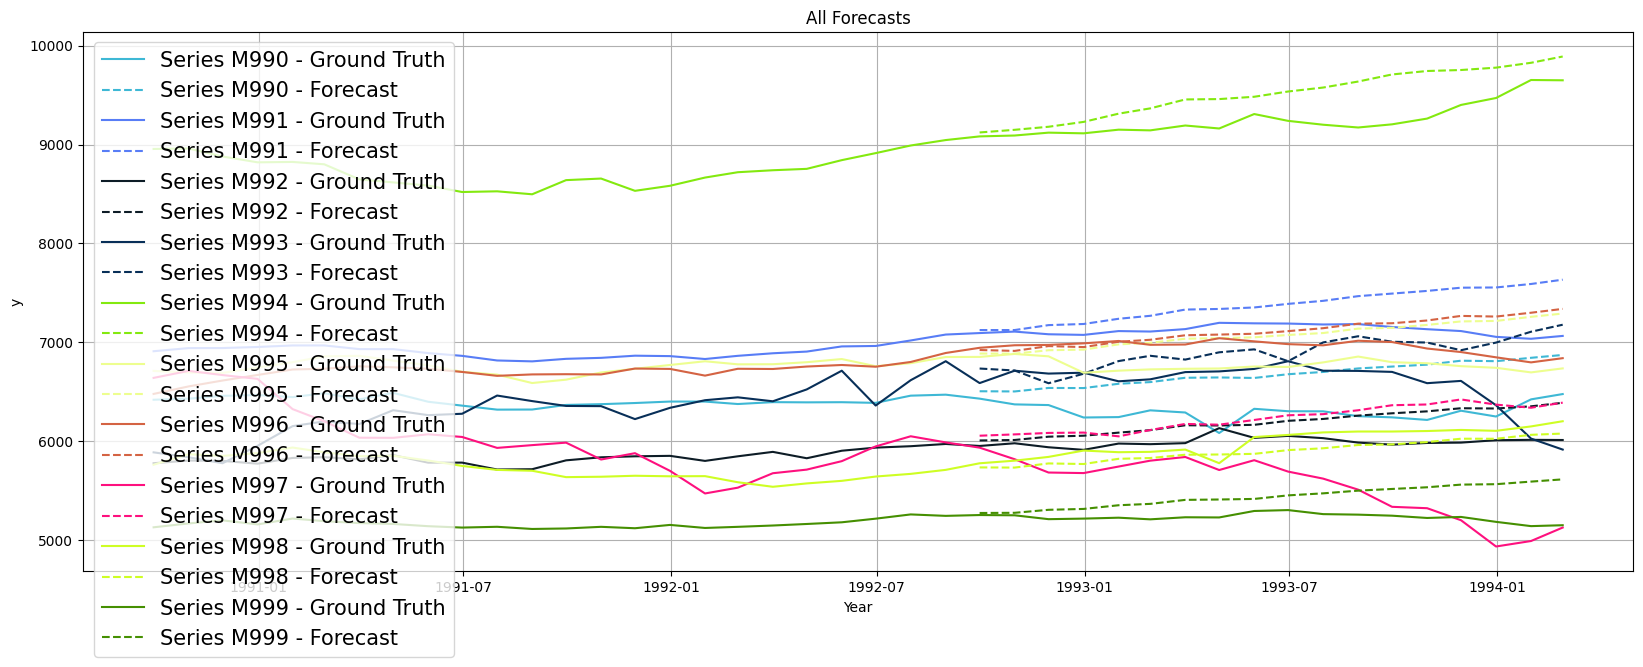

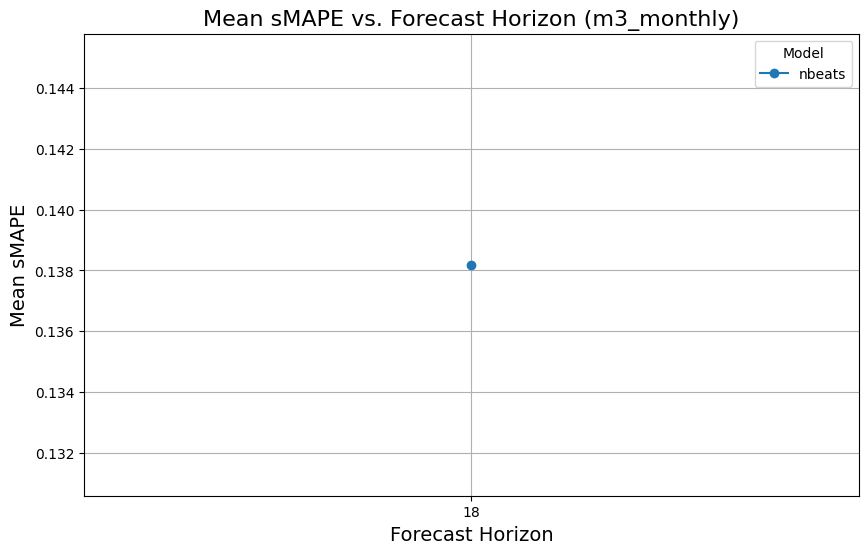

In [5]:
import run_exp as utils


def run_all_models():
    hydra.initialize(config_path="./../conf")
    cfg = hydra.compose(config_name="config.yaml")
    
    results, forecasts = utils.run_exp(cfg)
    results.to_csv("results.csv", index=False)

    return results, forecasts
results, forecasts = run_all_models()

In [6]:
print(forecasts)

      unique_id         ds       NBEATS
0            M1 1994-03-31  2400.114746
1            M1 1994-04-30  2398.695068
2            M1 1994-05-31  1880.209717
3            M1 1994-06-30  1930.788940
4            M1 1994-07-31  2197.697754
...         ...        ...          ...
25699      M999 1993-10-31  5536.040039
25700      M999 1993-11-30  5562.914551
25701      M999 1993-12-31  5567.224121
25702      M999 1994-01-31  5593.346680
25703      M999 1994-02-28  5616.052246

[25704 rows x 3 columns]


In [7]:
dic: DictConfig = DictConfig({
    'directory': './data/m3',
    'group': 'Monthly',
})


Y_all = utils.load_dataset('m3_monthly', dic)
y_truth = Y_all.groupby('unique_id').tail(18)
y_truth

Loading m3_monthly dataset...


,unique_id,ds,y
50,M1,1994-03-31,2280.0
51,M1,1994-04-30,480.0
52,M1,1994-05-31,5040.0
53,M1,1994-06-30,1920.0
54,M1,1994-07-31,840.0
...,...,...,...
167557,M999,1993-10-31,5225.9
167558,M999,1993-11-30,5236.3
167559,M999,1993-12-31,5186.6
167560,M999,1994-01-31,5143.4


In [8]:
joined = pd.merge(forecasts, y_truth, on='unique_id')
joined

,unique_id,ds_x,NBEATS,ds_y,y
0,M1,1994-03-31,2400.114746,1994-03-31,2280.0
1,M1,1994-03-31,2400.114746,1994-04-30,480.0
2,M1,1994-03-31,2400.114746,1994-05-31,5040.0
3,M1,1994-03-31,2400.114746,1994-06-30,1920.0
4,M1,1994-03-31,2400.114746,1994-07-31,840.0
...,...,...,...,...,...
462667,M999,1994-02-28,5616.052246,1993-10-31,5225.9
462668,M999,1994-02-28,5616.052246,1993-11-30,5236.3
462669,M999,1994-02-28,5616.052246,1993-12-31,5186.6
462670,M999,1994-02-28,5616.052246,1994-01-31,5143.4


In [9]:
## check for inf or nans and print rows
print(joined[joined['NBEATS'].isnull()])
print(joined[joined['NBEATS'].isna()])
print(joined[joined['NBEATS'].isin([np.nan, np.inf, -np.inf])])

Empty DataFrame
Columns: [unique_id, ds_x, NBEATS, ds_y, y]
Index: []
Empty DataFrame
Columns: [unique_id, ds_x, NBEATS, ds_y, y]
Index: []
Empty DataFrame
Columns: [unique_id, ds_x, NBEATS, ds_y, y]
Index: []


In [10]:
group_smape = joined.groupby('unique_id').apply(
    lambda group: smape(group['y'], group['NBEATS'])
)

# Map the computed SMAPE back to each row using the unique_id
joined['smape'] = joined['unique_id'].map(group_smape)
joined

,unique_id,ds_x,NBEATS,ds_y,y,smape
0,M1,1994-03-31,2400.114746,1994-03-31,2280.0,0.577843
1,M1,1994-03-31,2400.114746,1994-04-30,480.0,0.577843
2,M1,1994-03-31,2400.114746,1994-05-31,5040.0,0.577843
3,M1,1994-03-31,2400.114746,1994-06-30,1920.0,0.577843
4,M1,1994-03-31,2400.114746,1994-07-31,840.0,0.577843
...,...,...,...,...,...,...
462667,M999,1994-02-28,5616.052246,1993-10-31,5225.9,0.039516
462668,M999,1994-02-28,5616.052246,1993-11-30,5236.3,0.039516
462669,M999,1994-02-28,5616.052246,1993-12-31,5186.6,0.039516
462670,M999,1994-02-28,5616.052246,1994-01-31,5143.4,0.039516


In [11]:
# plot from the worst to the best
joined = joined.sort_values('smape', ascending=False)
joined


,unique_id,ds_x,NBEATS,ds_y,y,smape
313308,M584,1987-07-31,683.260315,1987-07-31,1025.0,1.311769
313429,M584,1988-01-31,606.627136,1988-08-31,17275.0,1.311769
313411,M584,1987-12-31,302.997192,1988-08-31,17275.0,1.311769
313412,M584,1987-12-31,302.997192,1988-09-30,23375.0,1.311769
313413,M584,1987-12-31,302.997192,1988-10-31,8575.0,1.311769
...,...,...,...,...,...,...
397439,M817,1993-08-31,7023.106934,1994-02-28,6974.0,0.009417
397440,M817,1993-09-30,7042.001465,1992-09-30,6896.0,0.009417
397441,M817,1993-09-30,7042.001465,1992-10-31,6922.0,0.009417
397442,M817,1993-09-30,7042.001465,1992-11-30,6948.0,0.009417


In [ ]:
from ray import tune

dic: DictConfig = DictConfig({
    'directory': './data/m3',
    'group': 'Monthly',
})

Y_all = utils.load_dataset('m3_monthly', dic)

# horizons: list = [i for i in range(1, 2)]
horizons: list = [12, 18, 24]
results = pd.DataFrame(columns=['model', 'horizon', 'smape'])

models = [
    # AutoDeepAR,
    # AutoNBEATS,
    AutoNHITS,
    # AutoTFT,
    # AutoTCN,
    # AutoRNN,
    # AutoLSTM
    # DeepAR,
    # NBEATS,
    # NHITS,
    # TFT,
    # TCN,
    # RNN,
    # LSTM
]


for modelCls in models:
    for horizon in horizons:

        
        print(f"Running {modelCls.__name__} with horizon {horizon}")


        # model = modelCls(
        #     h=horizon,
        #     input_size=24,
        #     loss=SMAPE(),
        #     early_stopping_patience=10,
        #     batch_size=32,
        #     valid_loss=SMAPE(),
        # )
        model = modelCls(
            num_samples = 5,
            loss=SMAPE(),
            h=horizon,
        )

        nf = NeuralForecast(
            models=[model],
            freq='M',
        )
        
        Y_hat = nf.cross_validation(df=Y_all, val_size=horizon)
        results = pd.concat([results, pd.DataFrame({
            'model': [model.__class__.__name__],
            'horizon': [horizon],
            'smape': [utils.calculate_smape(Y_hat, Y_hat, model.__class__.__name__)]
        })], ignore_index=True)

2025-02-12 00:20:29,769	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_23c8a_00000
Traceback (most recent call last):
  File "c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\ray\_private\worker.py", line 2772, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^

RuntimeError: No best trial found for the given metric: loss. This means that no trial has reported this metric, or all values reported for this metric are NaN. To not ignore NaN values, you can set the `filter_nan_and_inf` arg to False.

In [ ]:
results

model,nbeats,nhits,simpleMoe
horizon,,,
12,0.124858,0.126106,0.138079
18,0.139210,0.142841,0.159051
24,0.147199,0.148069,0.161115


In [ ]:
# show results in a graph

results = results.pivot(index='horizon', columns='model', values='smape')
results.plot()
plt.title('M3 Monthly')
plt.ylabel('SMAPE')
plt.xlabel('Horizon')
plt.show()


KeyError: 'horizon'

In [ ]:
# for each series in the dataset give the number of observations and the number of missing values
Y_all = utils.load_dataset('m3_monthly', dic)

missing = Y_all.groupby('unique_id')['y'].apply(lambda x: x.isna().sum()).reset_index(name='missing')
total = Y_all.groupby('unique_id')['y'].count().reset_index(name='total')
missing = pd.merge(missing, total, on='unique_id')
missing['missing_ratio'] = missing['missing'] / missing['total']
missing


Loading m3_monthly dataset...


c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\datasetsforecast\m3.py:108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(class_group.freq)


,unique_id,missing,total,missing_ratio
0,M1,0,68,0.0
1,M10,0,68,0.0
2,M100,0,69,0.0
3,M1000,0,134,0.0
4,M1001,0,134,0.0
...,...,...,...,...
1423,M995,0,134,0.0
1424,M996,0,134,0.0
1425,M997,0,134,0.0
1426,M998,0,134,0.0


In [ ]:
# sort by total number of total values ascending
missing.sort_values(ascending=True, by='total').head(10)

,unique_id,missing,total,missing_ratio
89,M1079,0,66,0.0
88,M1078,0,66,0.0
0,M1,0,68,0.0
1,M10,0,68,0.0
334,M13,0,68,0.0
1317,M9,0,68,0.0
445,M14,0,68,0.0
984,M6,0,68,0.0
496,M16,0,68,0.0
285,M1255,0,68,0.0
